In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Calibration B
Performed outside in Judaskogen at 2021-10-02 with Sensirion sensors {1, 2, 3, 4, B, D} and a DiscMini sensor.

In [2]:
# Set param [e.g. PM2.5 or NC2.5]
param = 'PM2.5'  # NC2.5
unit = 'µg/m³'   # #/cm³
date = '2021-12-14'

# Get calibration dataframe
c_df = get_calibrate_df(date, '../data/calibration_B')       # Sensirion sensors
disc_df = get_disc_df(date, '../data/calibration_B/disc.txt') # DiSC Mini Sensor

# Pick out calibration data
c_df = c_df[c_df.Timestamp >= f'{date} 15:00:00']
disc_df = disc_df[disc_df.Timestamp >= f'{date} 15:00:00']

# Remove first 150 seconds and last 30 seconds from DiSC sensor
disc_df = disc_df[15:-30]

# figure folder
fig_folder = '../results/calibration_B'

## 1 Overall initial statistics

General statistics for the whole dataset.

**Plot sensors over time**

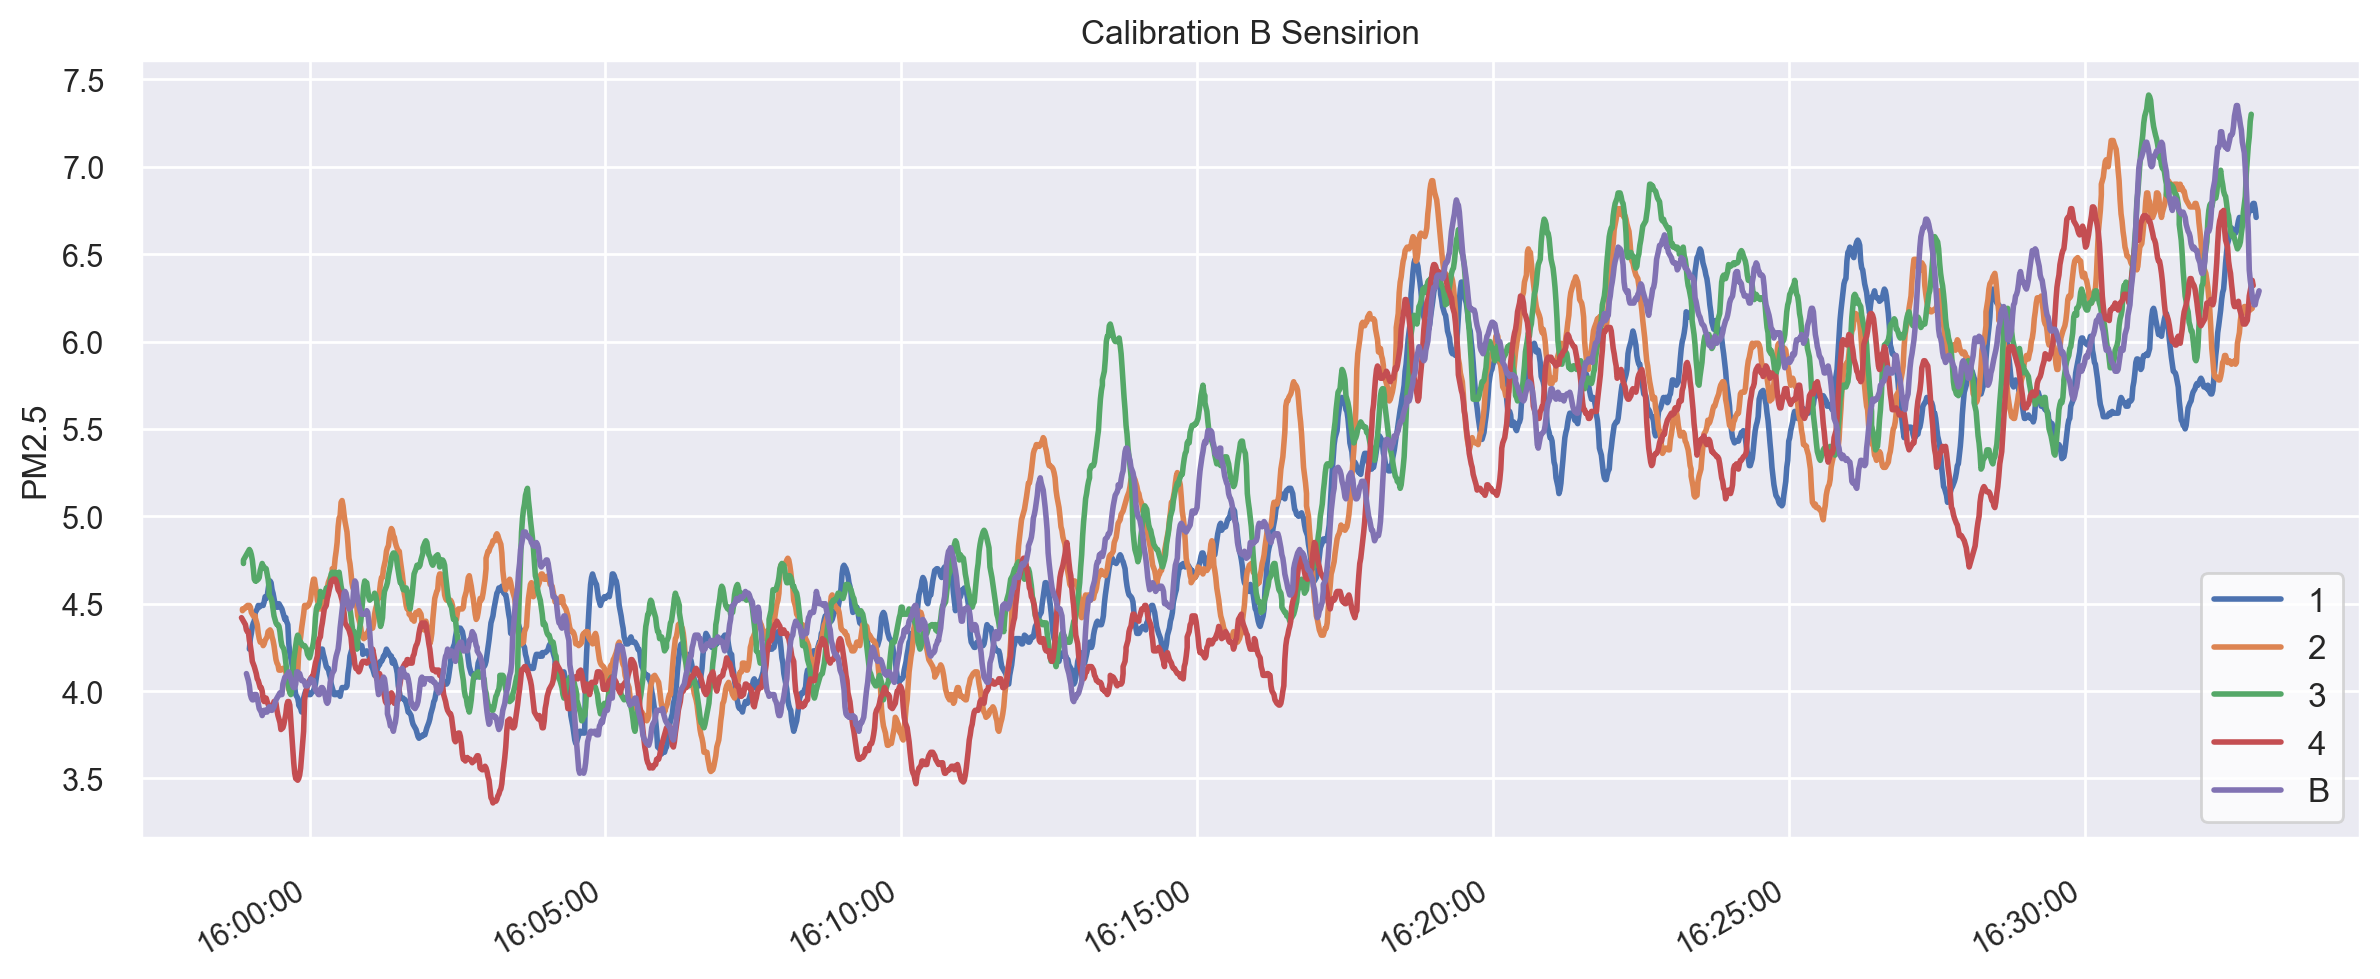

In [61]:
plot_sensors_over_time(
    c_df, 
    title='Calibration B Sensirion', 
    param=param, 
    fig_name=f'{fig_folder}/sensirion_over_time({param}).pdf'
)

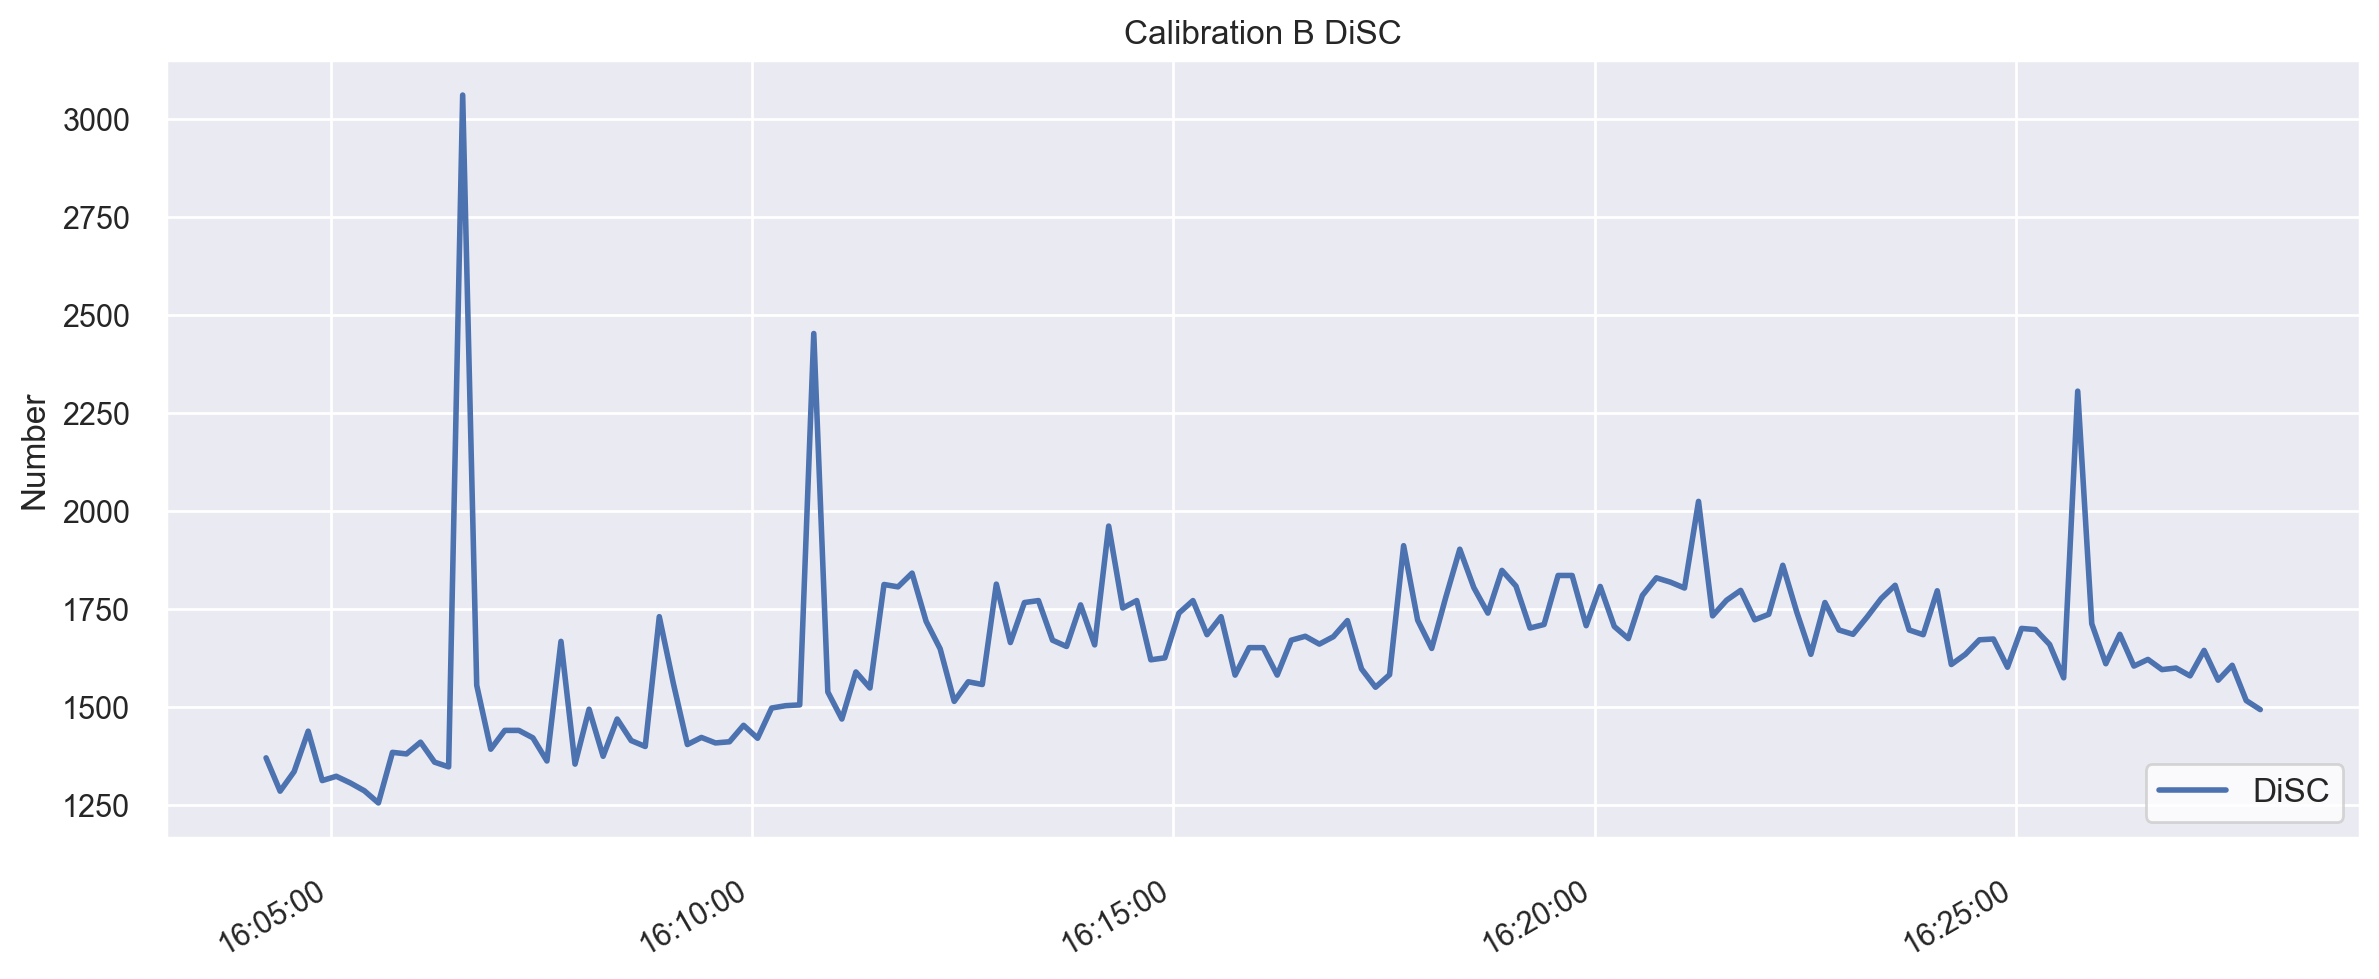

In [20]:
plot_sensors_over_time(
    disc_df,
    title='Calibration B DiSC',
    param='Number',
    fig_name=f'{fig_folder}/disc_over_time(Number).pdf'
)

**General statistics Sensirion**

In [62]:
grand_mean = c_df[param].mean()
grand_median = c_df[param].median()
grand_mode = c_df[param].mode()
grand_std = c_df[param].std()
confidence_interval = CI95(c_df[param].values)

print(f'Mean±Std: {param} = {round(grand_mean, 2)}±{round(grand_std, 2)} {unit}')
print(f'{param} = {round(grand_mean, 2)}±{round(confidence_interval, 2)} {unit}')
c_df[param].describe()

PM2.5 = 5.09±0.02 µg/m³


count    9517.000000
mean        5.088022
std         0.909419
min         3.360000
25%         4.280000
50%         4.920000
75%         5.880000
max         7.410000
Name: PM2.5, dtype: float64

**General statistic DiSC Mini**

In [64]:
confidence_interval_disc = CI95(disc_df['Number'].values)

disc_df['Number'].describe()

count     143.000000
mean     1643.293706
std       218.474862
min      1255.000000
25%      1509.500000
50%      1658.000000
75%      1740.000000
max      3060.000000
Name: Number, dtype: float64

#### Standard deviations, etc.

The "grand std" shows how much every sample varies from the total mean. The coefficient of variation is computed as follows:

$$CV = \frac{\sigma}{grand\ mean}$$

In [22]:
CV = grand_std / grand_mean
CV

0.17873722994258187

*How much do the medians vary from the total median?* (same formula as standard deviation but with medians)

In [23]:
median_diff = 0

for sensor, grp in c_df.groupby('Sensor'):
    median_diff += (grp[param].median() - grand_median) ** 2
    
median_diff = np.sqrt(median_diff / (len(c_df['Sensor'].unique()) - 1))

median_diff

0.29719522203427157

## 2 Central tendency and variability

The confidence interval is computed as follows:

$$CI95 = z\frac{\sigma}{\sqrt{n}}$$

where $z=1.96$ is the z-score for a 95% confidence interval, $\sigma$ the standard deviation, and $n$ the sample size.

In [24]:
central = c_df.groupby('Sensor').agg(
    {param: 
     ['mean', 'median', mode, 'min', 'max', x_range, sample_std, standard_error, CI95]
    }
)

central.head()

PM2.5                                                             \
            mean median  mode   min   max x_range sample_std standard_error   
Sensor                                                                        
1       4.999421   4.79  4.27  3.64  6.79    3.15   0.795576       0.018247   
2       5.171565   5.03  4.47  3.54  7.15    3.61   0.888444       0.020361   
3       5.262387   5.29  4.53  3.77  7.41    3.64   0.900808       0.020655   
4       4.854310   4.49  4.05  3.36  6.77    3.41   0.935279       0.021429   
B       5.152562   4.97  3.98  3.53  7.35    3.82   0.961260       0.022024   

                  
            CI95  
Sensor            
1       0.035764  
2       0.039907  
3       0.040484  
4       0.042000  
B       0.043167

**Comment**

Sensor 3 has the largest range and highest standard deviation. Sensor 1 has the smallest range and the lowest standard deviation.

## 3 Distribution
How is the data distributed?

### 3.1 Box plots

### Sensirion Sensors

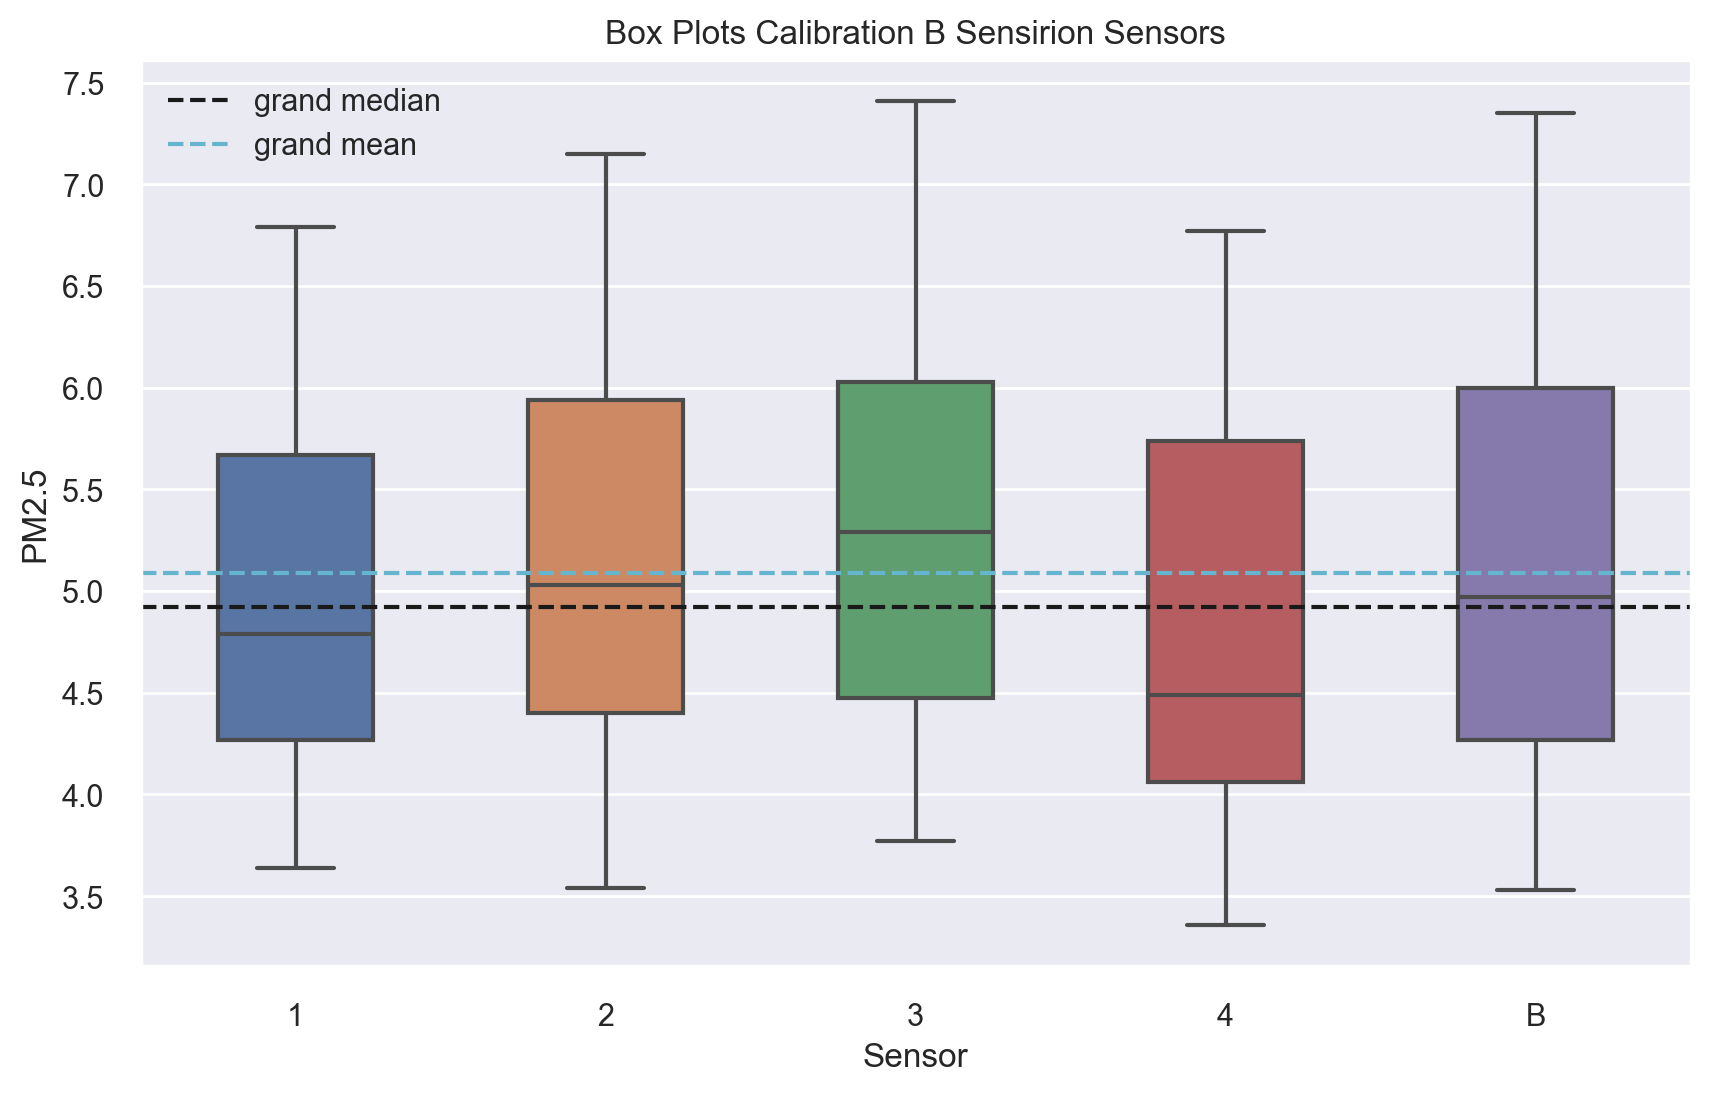

In [66]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(
    x='Sensor', 
    y=param, 
    data=c_df, 
    width=0.5, 
    #showmeans=True,
    #meanline=True,
    #meanprops={'color': '#fd3', 'linewidth': '1'}
)

plt.axhline(c_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(c_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Calibration B Sensirion Sensors')
plt.savefig(f'{fig_folder}/box_plots_sensirion({param}).pdf')
plt.show()

**Comment**

No outliers.


**Quantiles**

In [94]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = c_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles.head()

PM2.5                                                     \
            Q1    Q2    Q3     IQR lowerLimit upperLimit outliers   
Sensor                                                              
1       4.2700  4.79  5.67  1.4000    2.17000    7.77000      0.0   
2       4.4000  5.03  5.94  1.5400    2.09000    8.25000      0.0   
3       4.4725  5.29  6.03  1.5575    2.13625    8.36625      0.0   
4       4.0600  4.49  5.74  1.6800    1.54000    8.26000      0.0   
B       4.2700  4.97  6.00  1.7300    1.67500    8.59500      0.0   

                             
       prcnt_outliers count  
Sensor                       
1                 0.0  1901  
2                 0.0  1904  
3                 0.0  1902  
4                 0.0  1905  
B                 0.0  1905

### DiSC Mini

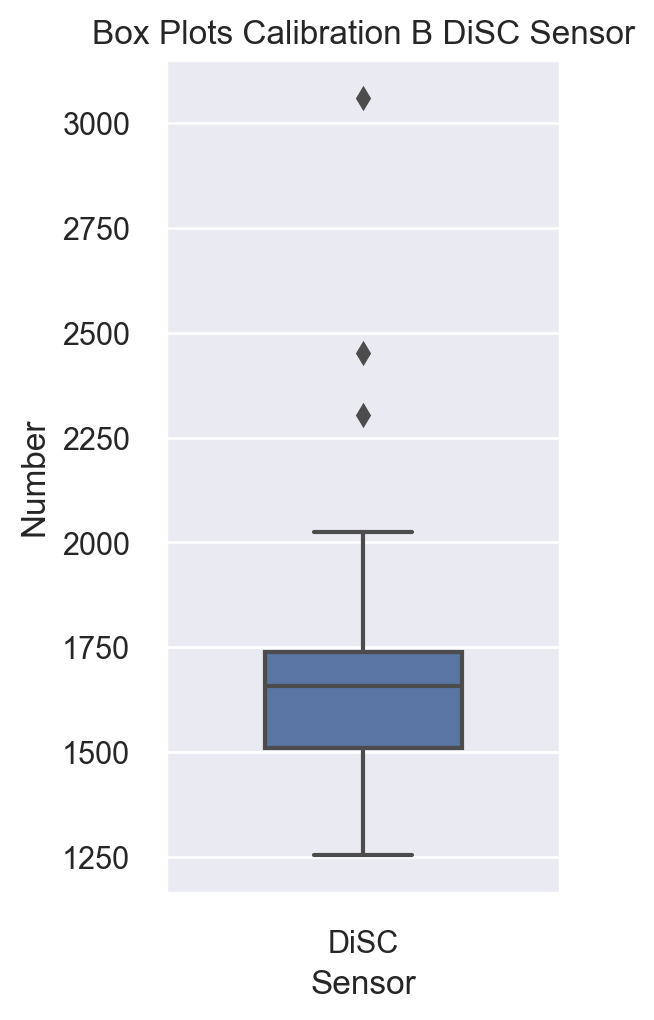

In [92]:
fig, ax = plt.subplots(figsize=[3,5], dpi=200)

sns.boxplot(
    x='Sensor', 
    y='Number', 
    data=disc_df, 
    width=0.5, 
    #showmeans=True,
    #meanline=True,
    #meanprops={'color': '#fd3', 'linewidth': '1'}
)

plt.tight_layout()
plt.title('Box Plots Calibration B DiSC Sensor')
plt.savefig(f'{fig_folder}/box_plots_disc(Number).pdf')
plt.show()

**Quantiles DiSC Mini**

In [98]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles_disc = disc_df.groupby('Sensor').agg(
    {'Number': 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles_disc.head()

Number                                                    \
            Q1    Q2    Q3    IQR lowerLimit upperLimit outliers   
Sensor                                                             
DiSC    1509.5  1658  1740  230.5    1163.75    2085.75        3   

                             
       prcnt_outliers count  
Sensor                       
DiSC         2.097902   143

**Outliers**

In [102]:
# Get exact values of outliers
lower = quantiles_disc['Number']['lowerLimit']['DiSC']
upper = quantiles_disc['Number']['upperLimit']['DiSC']
disc_df.loc[(disc_df['Number'] < lower) | (disc_df['Number'] > upper)]

Time  Number  Size  LDSA Filter  Diff           Timestamp Sensor
29    294.5    3060  46,9  7,96   6,22  3,24 2021-12-14 16:06:34   DiSC
54    544.5    2452  55,6   7,7   6,41  2,75 2021-12-14 16:10:44   DiSC
144  1444.5    2305  65,7  8,72   7,63  2,75 2021-12-14 16:25:44   DiSC

### 3.3 Histograms

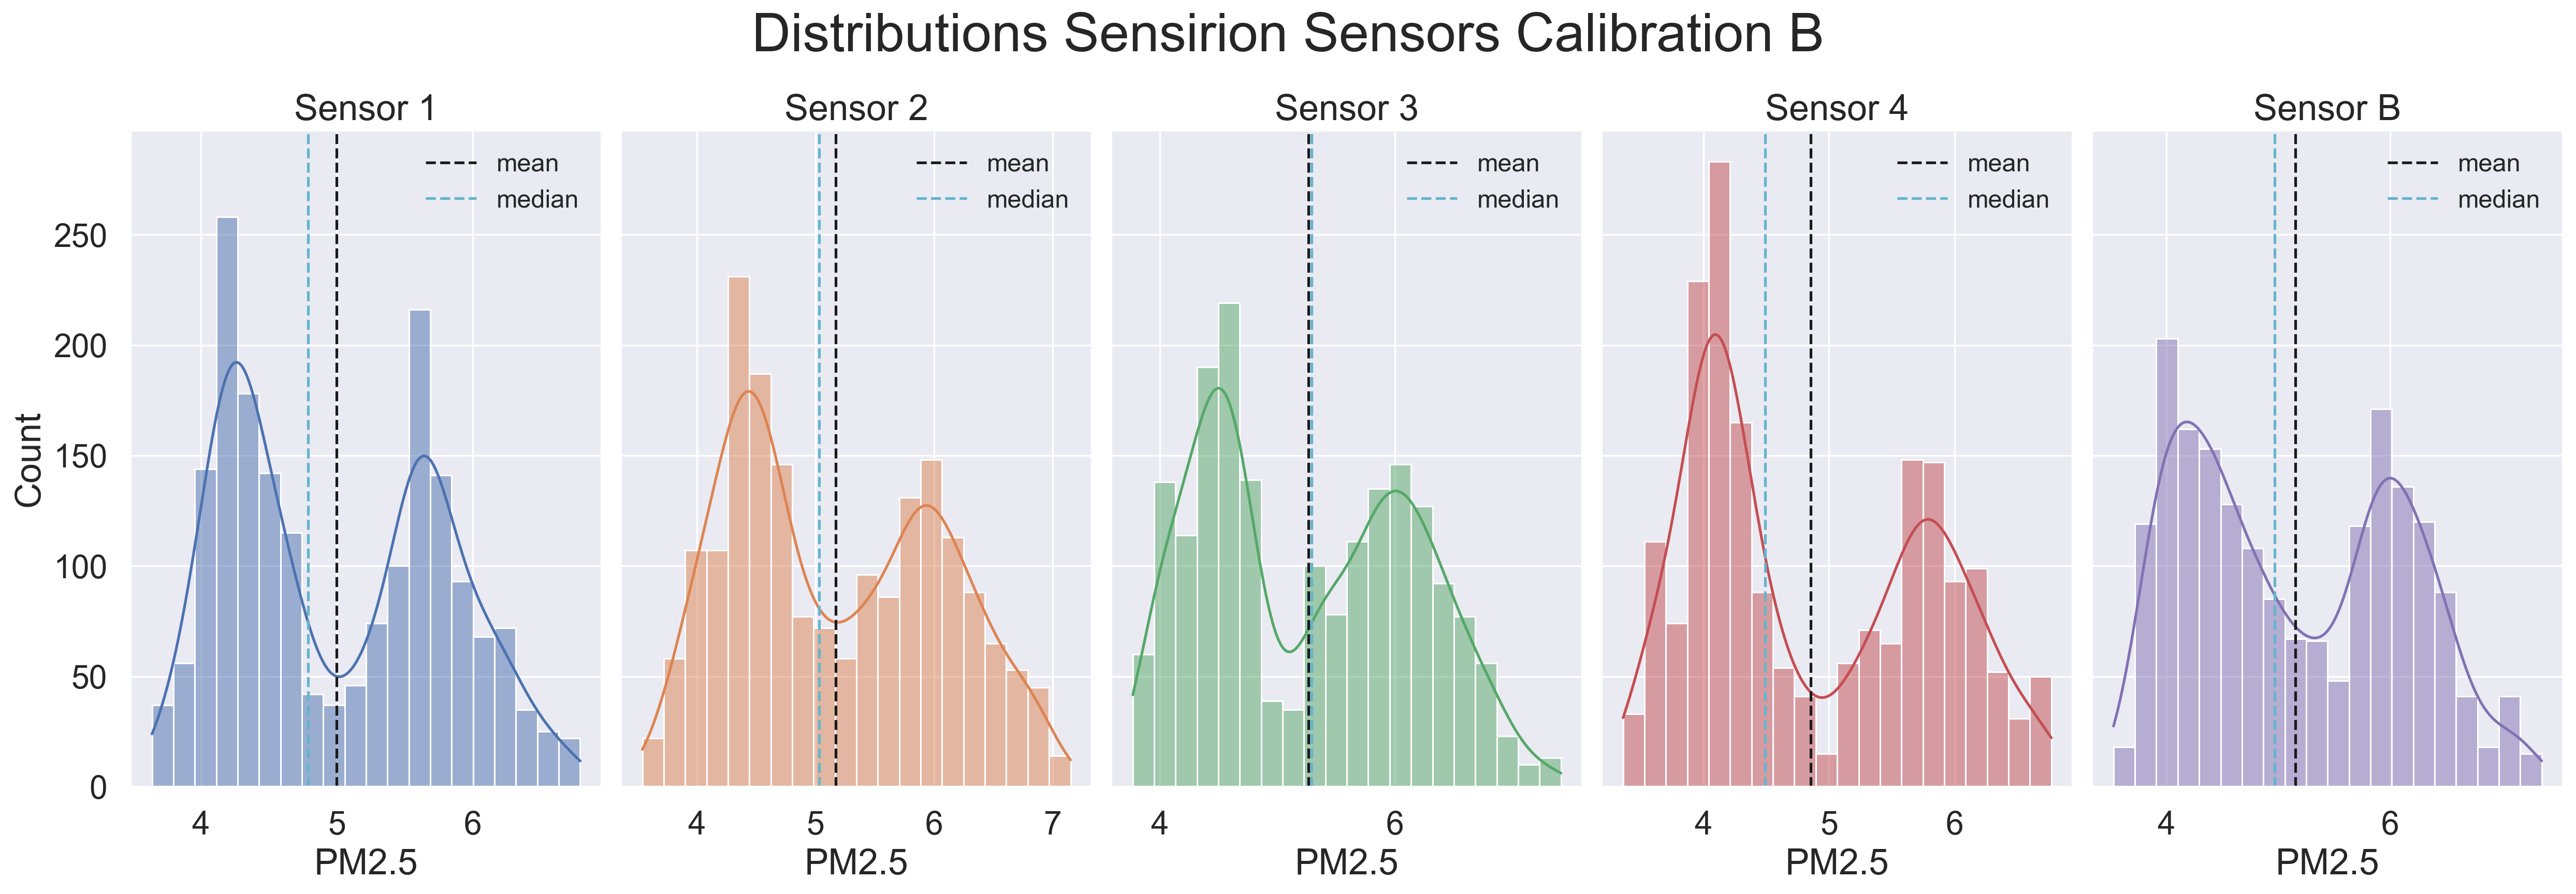

In [103]:
plot_sensor_distributions(
    c_df, 
    title='Distributions Sensirion Sensors Calibration B', 
    fig_name=f'{fig_folder}/distributions_sensirion{param}.pdf', 
    bins=20, 
    param=param
)

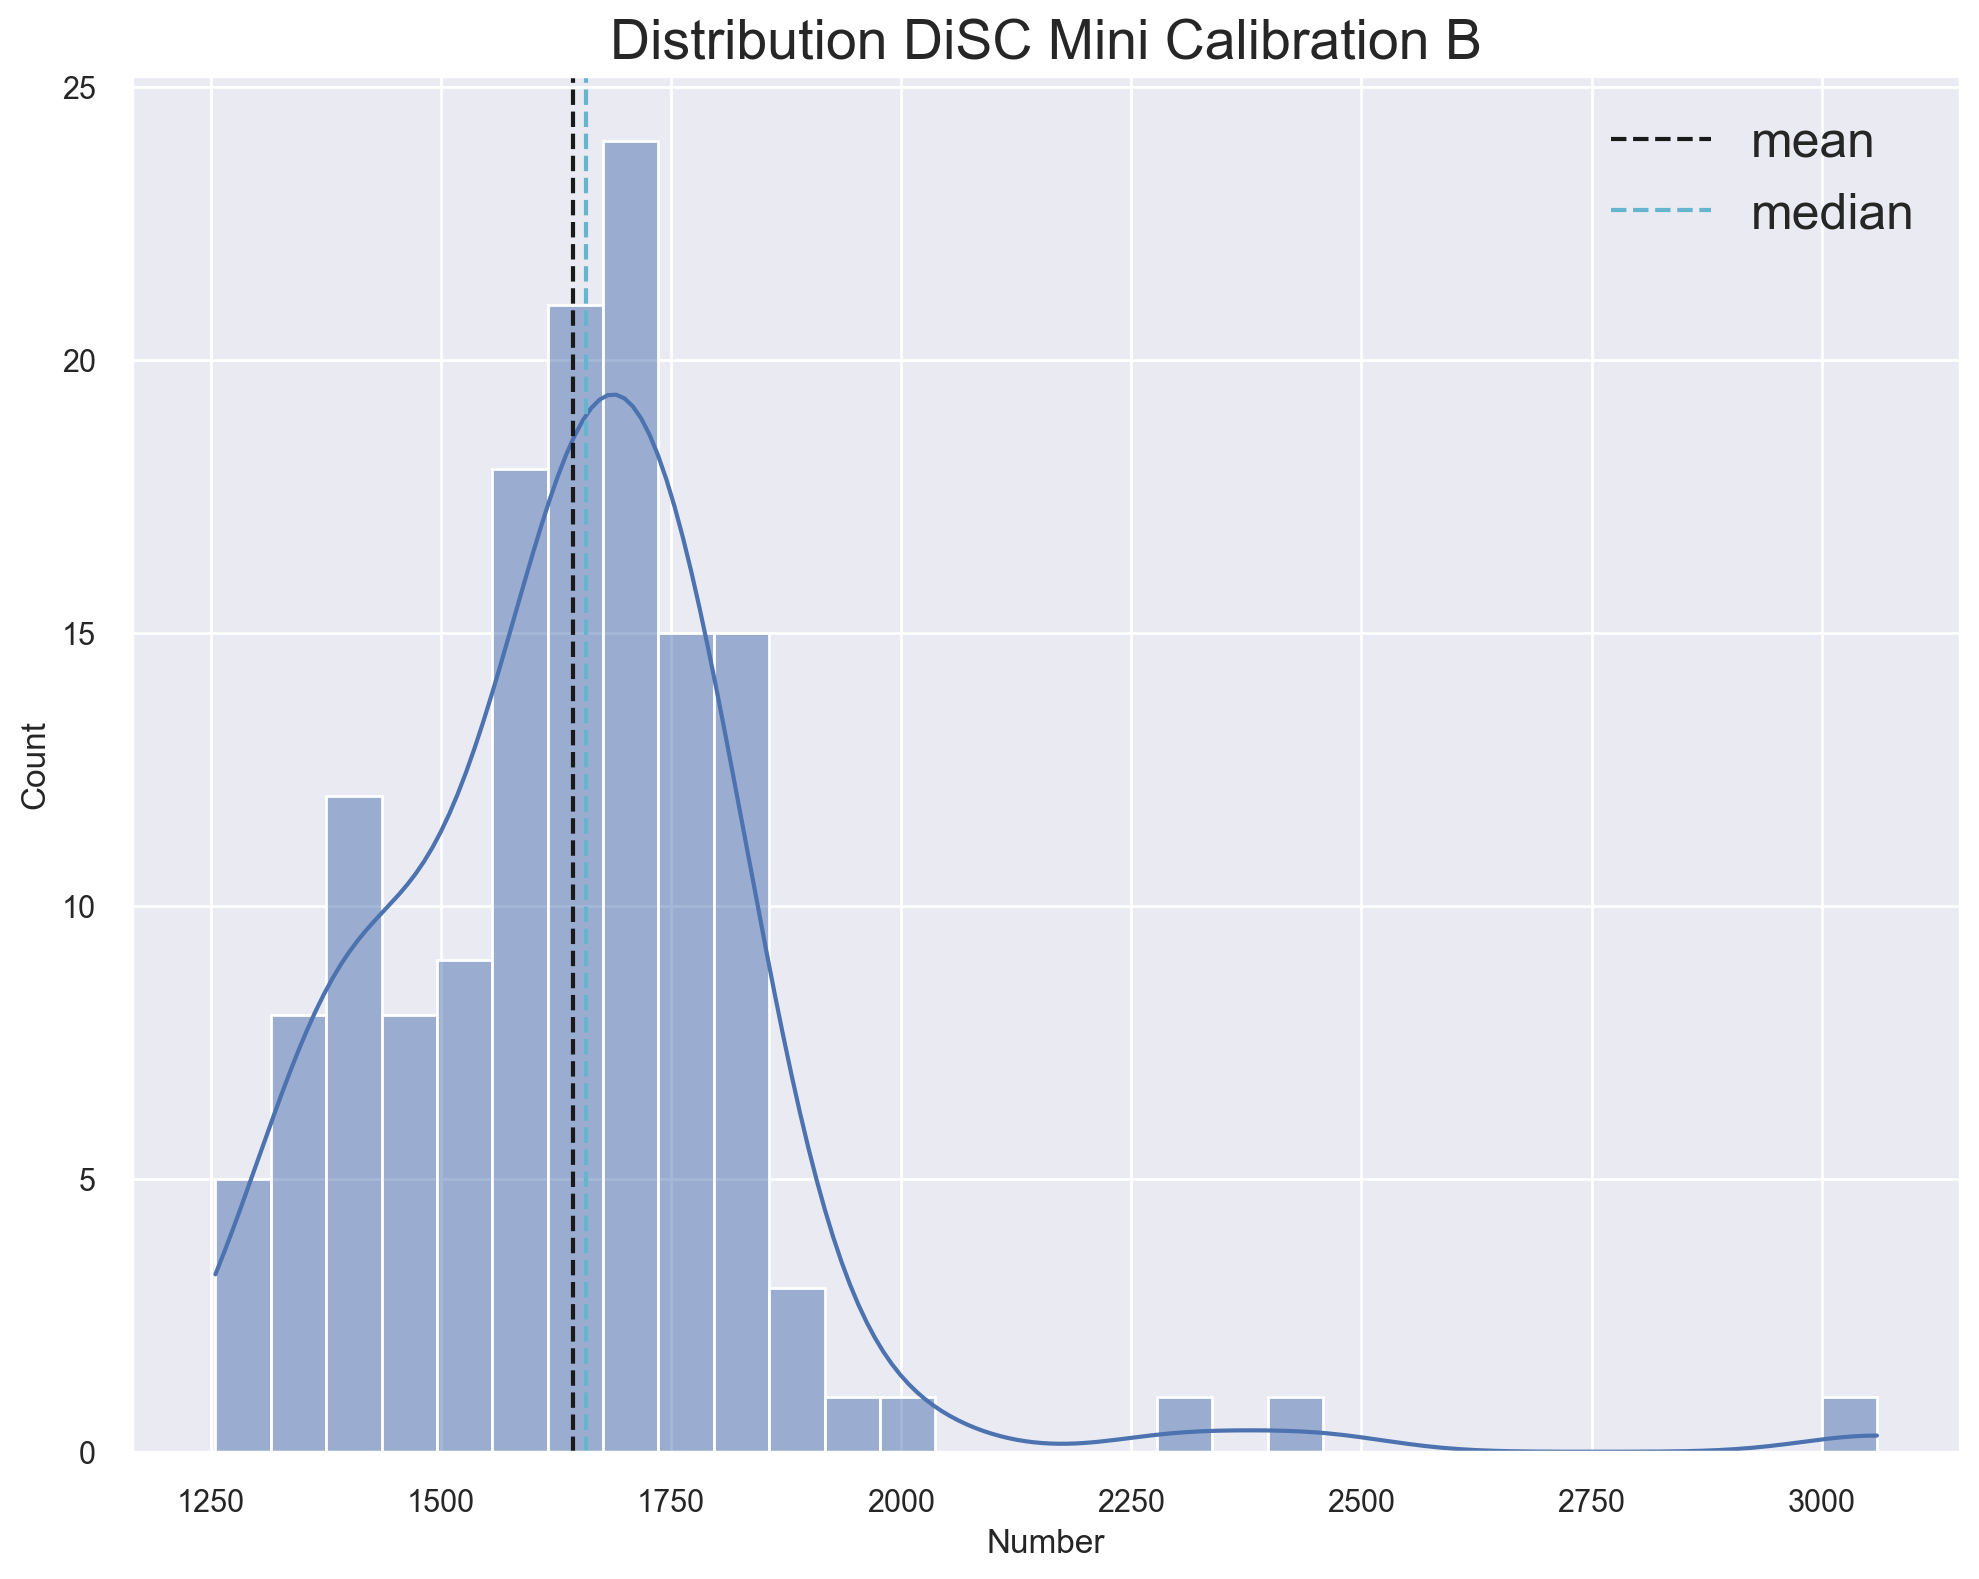

In [109]:
fig, ax = plt.subplots(figsize=[10, 8], dpi=200)

sns.histplot(disc_df, x='Number', kde=True, bins=30)
ax.axvline(disc_df['Number'].mean(), c="k", linestyle="--", label="mean")
ax.axvline(disc_df['Number'].median(), c="c", linestyle="--", label="median")
ax.set_title('Distribution DiSC Mini Calibration B', fontsize=20)

ax.legend(fontsize=18)
plt.tight_layout()
plt.savefig(f'{fig_folder}/distribution_disc(Number).pdf')

plt.show()

**Comment**

This gives us a nice general overview of the individual sensor distributions. They seem to roughly follow normal distributions, but to what extent? To get more exact values, let's use QQ-plots, skew, and kurtosis.

### 3.4 Normal distribution

In [110]:
normal = c_df.groupby('Sensor').agg({param: [skew, kurtosis]})

normal.head(10)

PM2.5          
            skew  kurtosis
Sensor                    
1       0.243270 -1.249703
2       0.245710 -1.163733
3       0.205641 -1.214059
4       0.338596 -1.312397
B       0.235388 -1.217676

Compare with values

**Comment**

Sensor 4 has the highest absolute skew and kurtosis. Sensor 3 has the lowest skew while Sensor 2 has the least amount of kurtosis.

#### QQ Plots

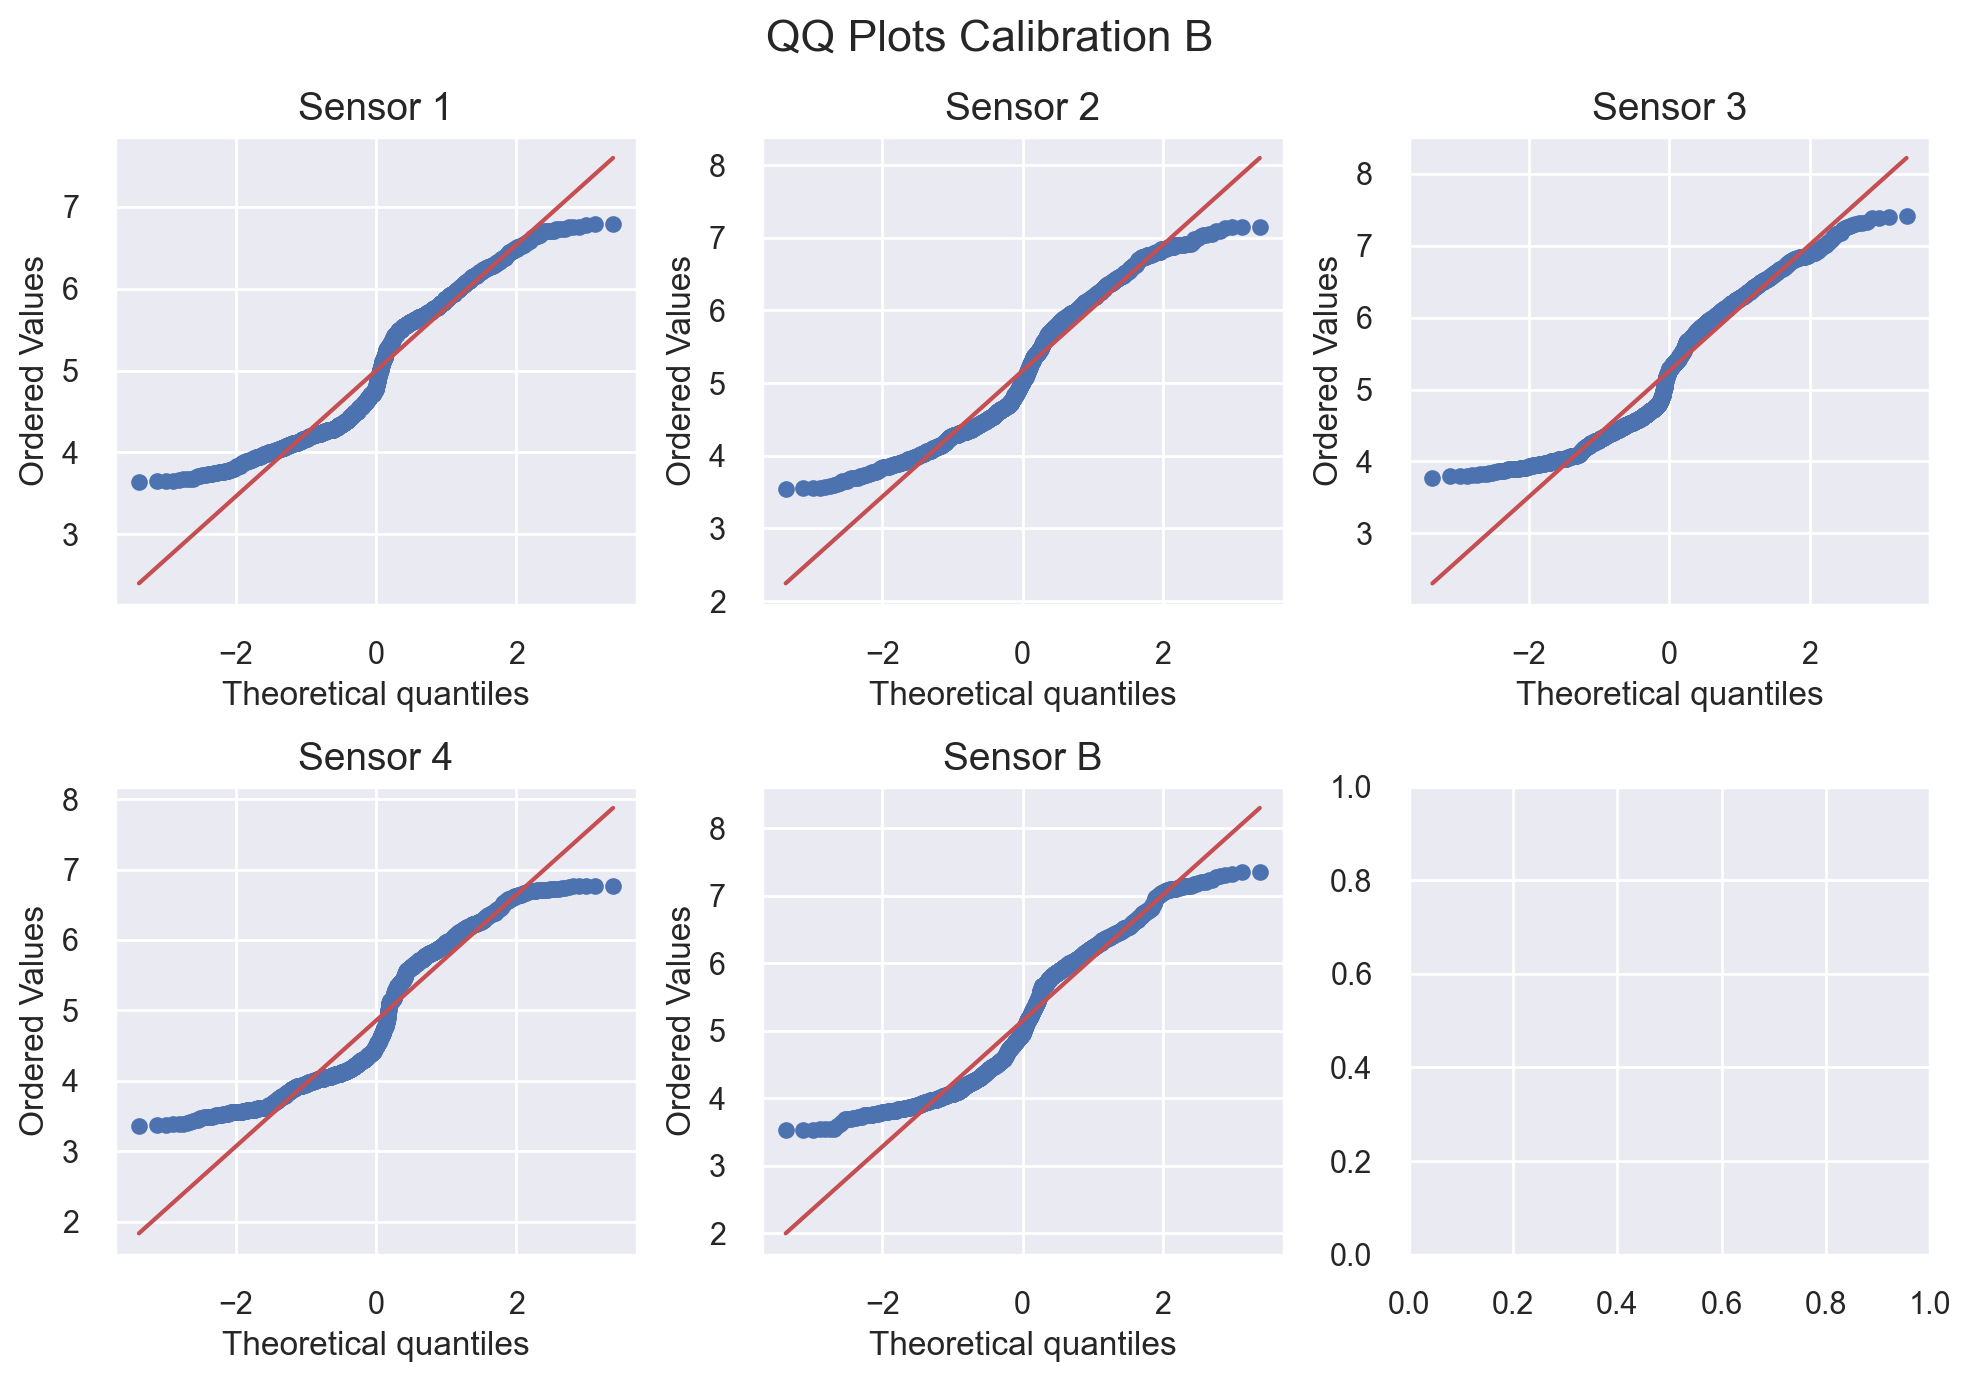

In [111]:
plot_QQ_plots(
    c_df, 
    title='QQ Plots Calibration B', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots{param}.pdf'
)

**Comment**

Based on visuals from the above graphs, the sensors do not follow a normal distribution. This is due to the particle count being subdivided into two.

## 4 Comparison among sensors and between them

### 4.1 Distribution

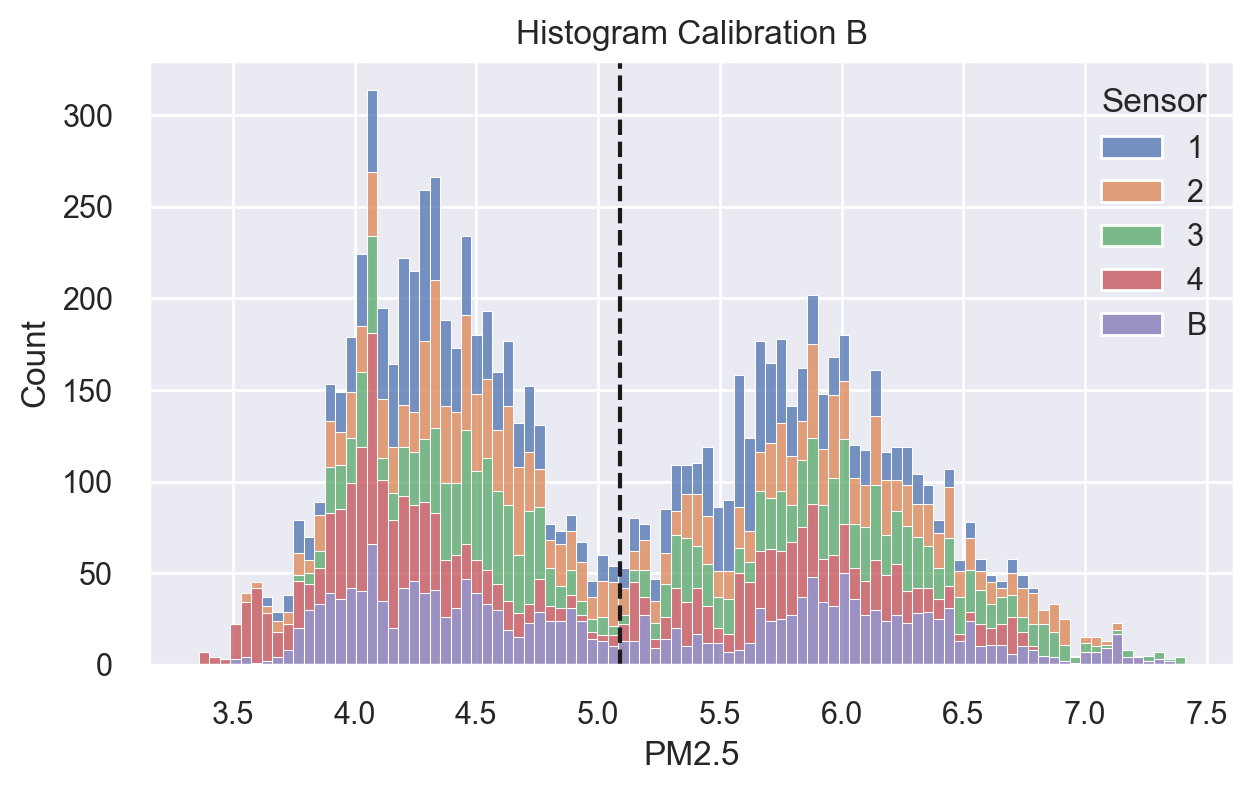

In [112]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(c_df, x=param, hue='Sensor', multiple='stack', bins=94)
plt.axvline(grand_mean, c='k', linestyle='--', label='mean', linewidth=1.5)
plt.title('Histogram Calibration B')

plt.savefig(f'{fig_folder}/histogram{param}.pdf')

plt.show()

In [113]:
grand_skew = stats.skew(c_df[param], bias=False)
grand_kurtosis = stats.kurtosis(c_df[param], bias=False)

print(f'Skew: {grand_skew}')
print(f'Kurtosis: {grand_kurtosis}')
print(f'Std: {grand_std}')

Skew: 0.2505312746721487
Kurtosis: -1.1668537638653482
Std: 0.9094190450470692


**Comment**

## 5 Other 

### 5.1 Pairplots

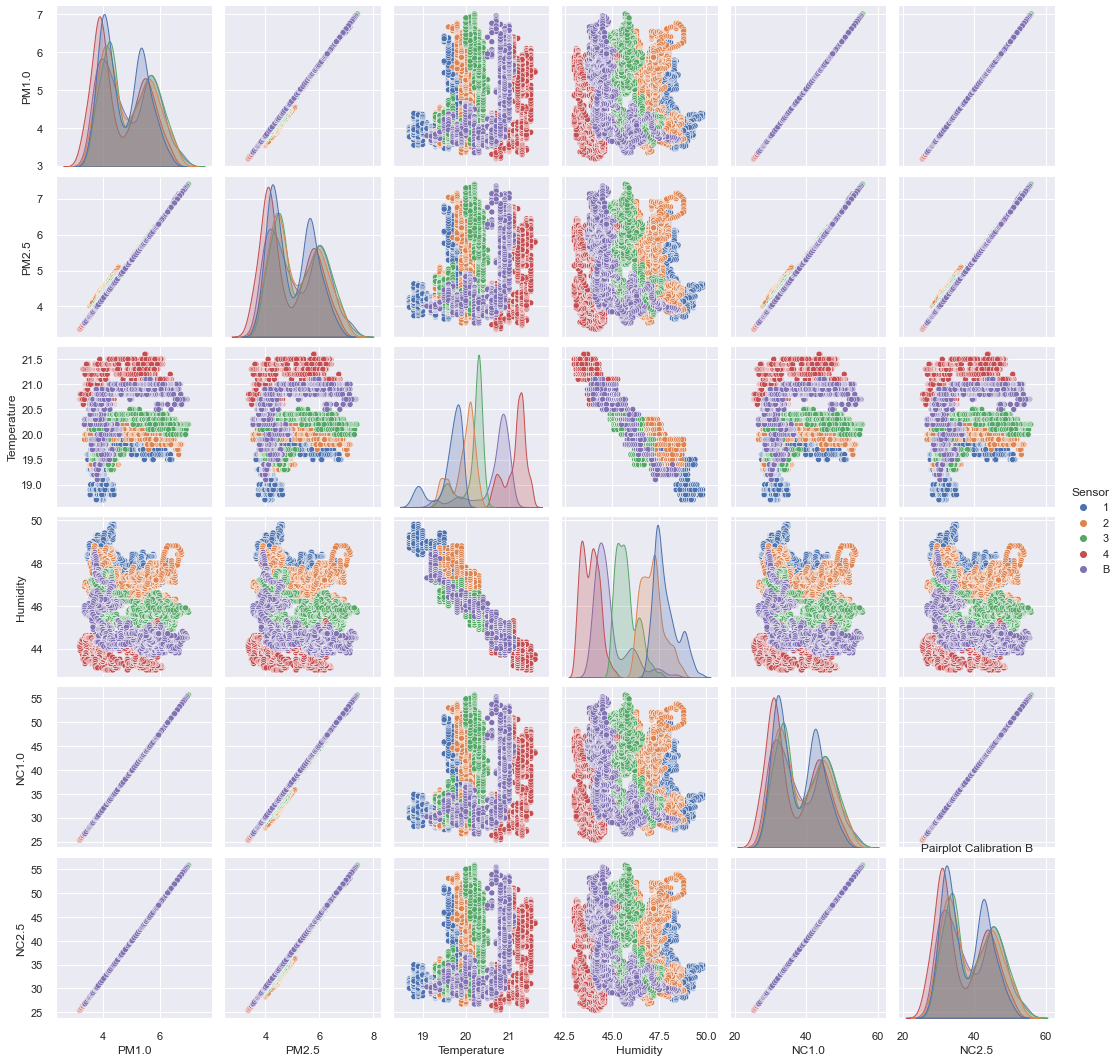

In [16]:
pair_df = c_df.copy()

pair_df = pair_df[['PM1.0', 'PM2.5', 'Temperature', 'Humidity', 'NC1.0', 'NC2.5', 'Sensor']]

sns.pairplot(pair_df, hue='Sensor')

plt.savefig(f'{fig_folder}/pariplot.pdf')

plt.show()

## ANOVA

In [31]:
anova_df = perform_ANOVA(
    c_df,
    param=param,
    alpha=0.1,
)

anova_df

0
SST                                7870.141183
SSW                                7672.113679
SSB                                 198.027504
Alpha                                      0.1
F-stat                               61.379357
F-crit                                1.945451
P-value                                    0.0
F-stat > F-crit  True (Significant Difference)
p-value < alpha  True (Significant Difference)

In [53]:
sensor_data = []

for sensor in c_df['Sensor'].unique():
    sensor_data.append(c_df.loc[c_df['Sensor'] == sensor][param].values)
    
f_oneway(*sensor_data)

F_onewayResult(statistic=61.37935710258704, pvalue=2.783537753343303e-51)

### Tukey Test

In [55]:
tukey_df = c_df[[param, 'Sensor']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Sensor'],
    alpha=0.1
)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.1721  0.001  0.1005  0.2438   True
     1      3    0.263  0.001  0.1913  0.3346   True
     1      4  -0.1451  0.001 -0.2167 -0.0735   True
     1      B   0.1531  0.001  0.0815  0.2248   True
     2      3   0.0908 0.0156  0.0192  0.1624   True
     2      4  -0.3173  0.001 -0.3888 -0.2457   True
     2      B   -0.019    0.9 -0.0906  0.0526  False
     3      4  -0.4081  0.001 -0.4797 -0.3365   True
     3      B  -0.1098 0.0015 -0.1814 -0.0382   True
     4      B   0.2983  0.001  0.2267  0.3698   True
----------------------------------------------------


# Difference from Mean

In [3]:
# Compute sensor "Mean" as the mean of all sensor for every timestamp

mean_df = c_df.groupby('Timestamp').mean()
mean_df['Timestamp'] = mean_df.index
mean_df['Sensor'] = 'Mean'
mean_df['UID'] = 'Mean'

mean_df.reset_index(drop=True, inplace=True)

total_df = pd.concat([c_df, mean_df])

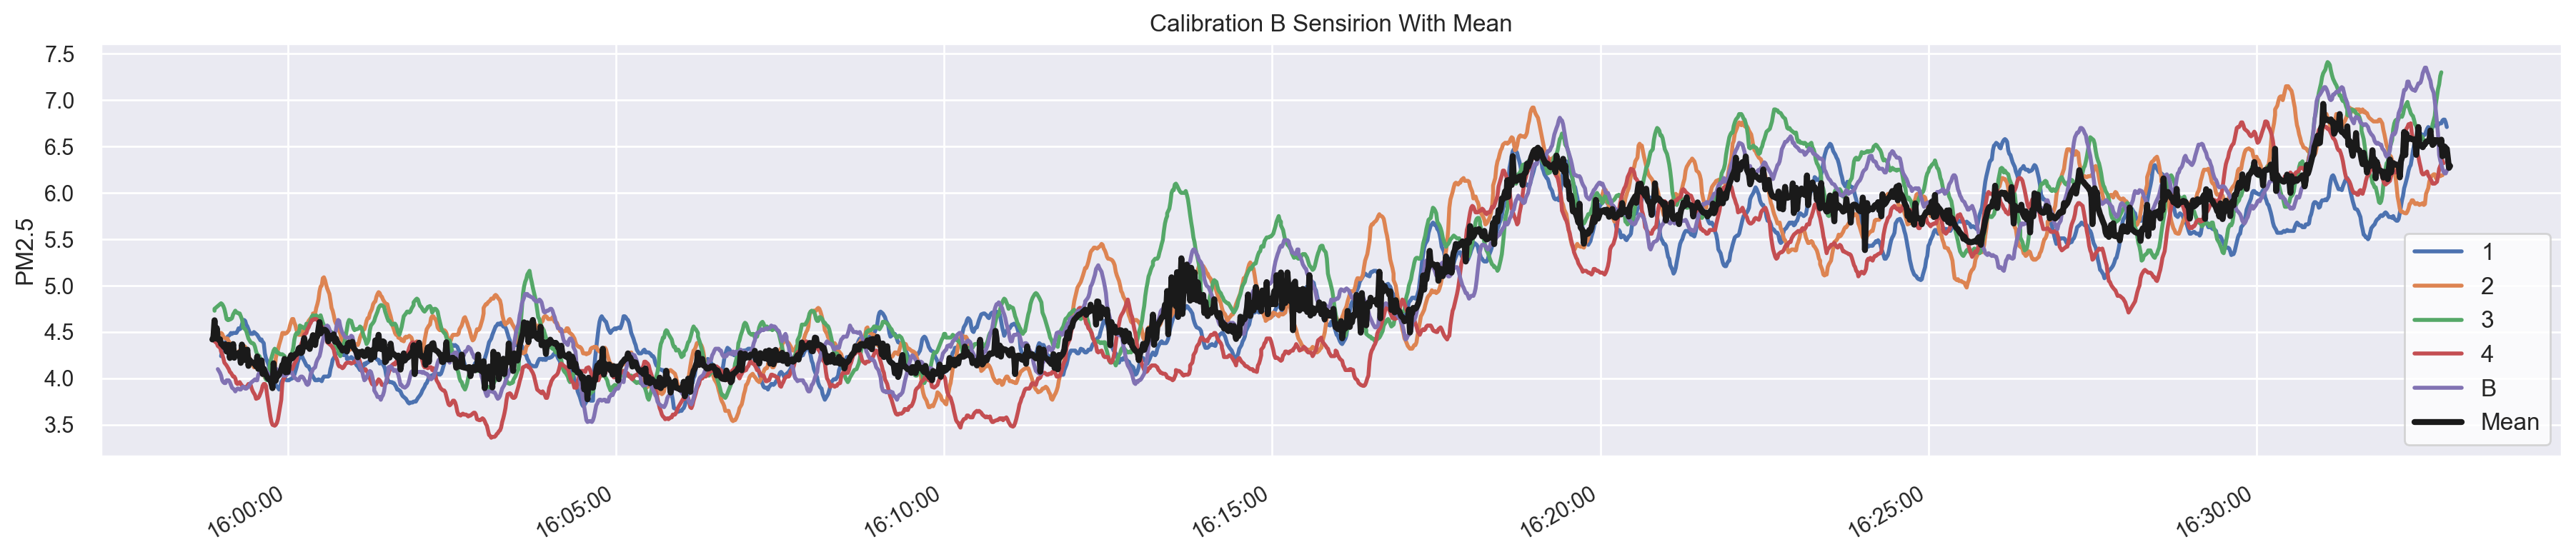

In [4]:
plot_sensors_over_time(
    total_df, 
    title='Calibration B Sensirion With Mean', 
    param=param, 
    size=[18,4],
    fig_name=f'{fig_folder}/sensirion_over_time_mean({param}).pdf'
)

In [7]:
# How much do the sensors differ from the mean line?

diffs = {}

for timestamp, grp in c_df.groupby('Timestamp'):
    stamp_mean = grp[param].mean()
    
    for sensor, sensor_grp in grp.groupby('Sensor'):
        if sensor not in diffs:
            diffs[sensor] = []
        
        diffs[sensor].append(sensor_grp.iloc[0][param] - stamp_mean)

[]

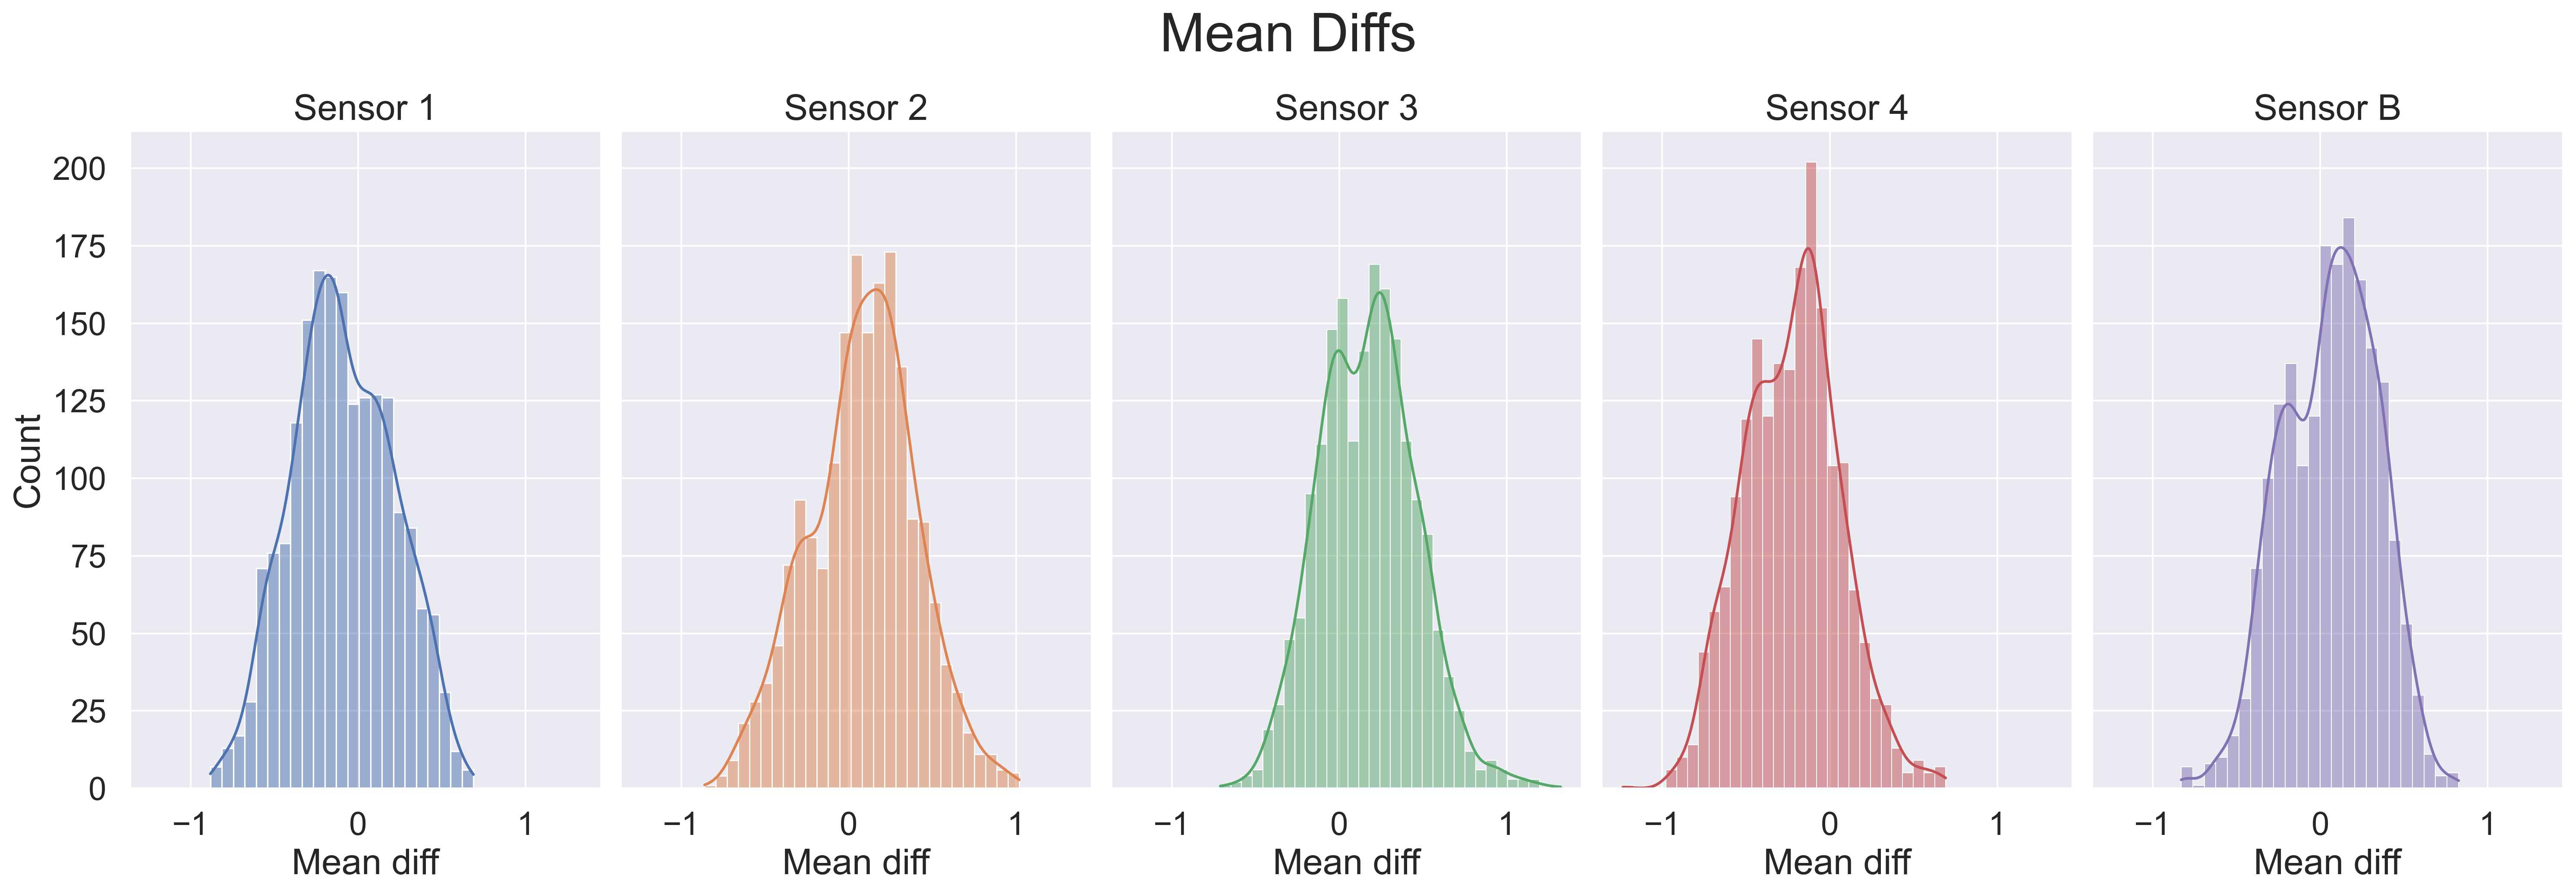

In [9]:
fig, axs = plt.subplots(ncols=len(c_df['Sensor'].unique()), dpi=300, sharey=True, sharex=True, figsize=[20, 7])

i = 0
for sensor in c_df['Sensor'].unique():
   
    sns.histplot(diffs[sensor], ax=axs[i], kde=True, color=sns.color_palette()[i])
 
    axs[i].tick_params(axis="x", labelsize=18)
    axs[i].tick_params(axis="y", labelsize=18)

    axs[i].set_xlabel('Mean diff', fontsize=20)
    axs[i].set_ylabel("Count", fontsize=20)
    axs[i].set_title(f"Sensor {sensor}", fontsize=20)

    i += 1

plt.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('Mean Diffs', fontsize=30)

fig_name=f'{fig_folder}/sensirion_diffs({param}).pdf'

if fig_name:
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.plot()

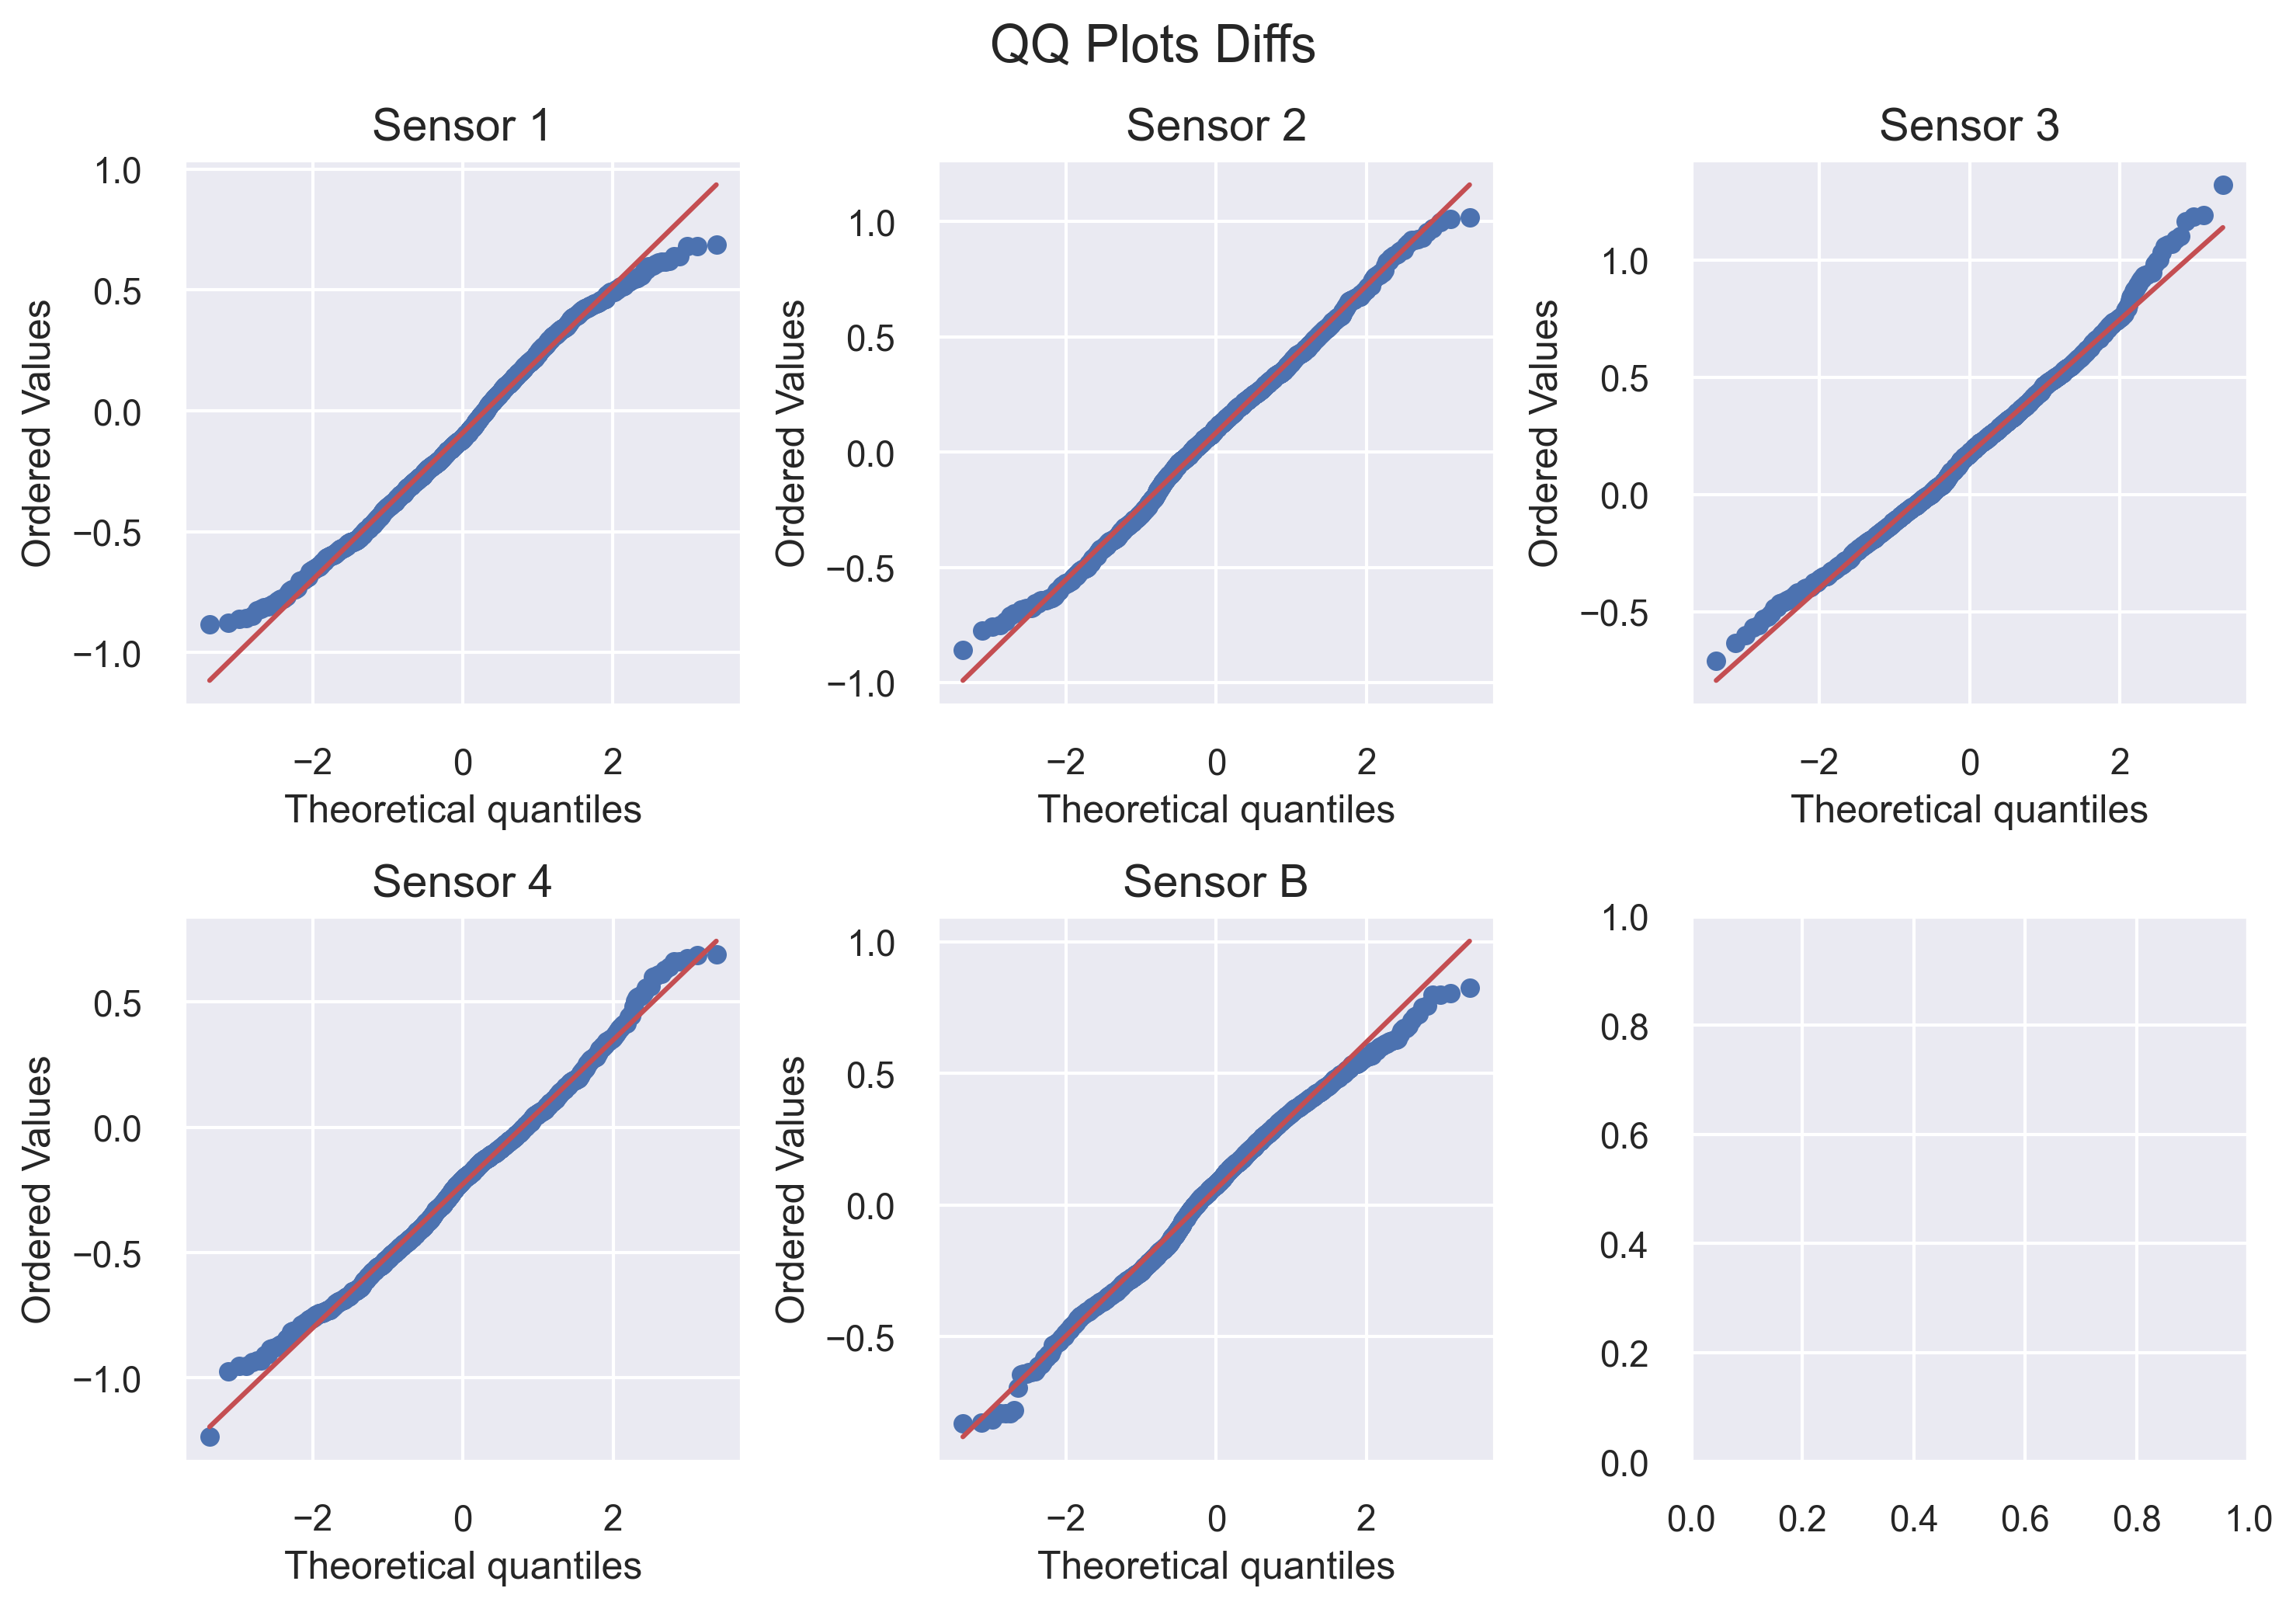

In [10]:
# Gör QQ-plots
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[10, 7], dpi=300)

for sensor, ax in zip(c_df['Sensor'].unique(), axs.flatten()):
    stats.probplot(diffs[sensor], dist="norm", plot=ax)
    ax.set_title(f"Sensor {sensor}", fontsize=14)

plt.suptitle('QQ Plots Diffs', fontsize=16)
plt.tight_layout()

fig_name=f'{fig_folder}/sensirion_diffs_qqplots({param}).pdf'
if fig_name:
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.show()